# Detecção de Veículos com YOLOv5 Adaptado (Treinamento e Avaliação)  
### Referente à Entrega 1 do Projeto PBL - Fase 6

## PBL Fase 6 – Visão Computacional com YOLOv5

### Reconhecimento de Veículos: Carros e Motos

Este notebook apresenta o desenvolvimento de um sistema de visão computacional utilizando a arquitetura YOLOv5 para detectar e classificar dois tipos de veículos: carros e motos. A atividade faz parte da Fase 6 do Projeto Baseado em Problemas (PBL) da FIAP, no contexto da empresa fictícia FarmTech Solutions, que está explorando o uso de inteligência artificial em aplicações de segurança patrimonial e automação.

O objetivo principal é treinar um modelo YOLOv5 com base em imagens rotuladas manualmente e avaliar seu desempenho na detecção dos objetos escolhidos. O projeto envolve também a comparação de resultados com diferentes quantidades de épocas de treinamento.

### Objetivos do notebook

- Organizar e utilizar um dataset rotulado manualmente.
- Treinar um modelo YOLOv5 com 30 e 60 épocas.
- Avaliar acurácia, perda e desempenho.
- Realizar inferência em imagens de teste.
- Apresentar conclusões com base nos resultados obtidos.

### Aquisição e preparação do dataset

Para este projeto, foram utilizadas imagens de dois objetos distintos: **carros** e **motos**. As imagens foram obtidas manualmente a partir de pesquisas com licenciamento livre (Creative Commons) e screenshots, priorizando variedade de ângulos e contextos.

Após a coleta, foram selecionadas:

- 40 imagens de carros
- 40 imagens de motos

As imagens foram rotuladas manualmente utilizando a plataforma [MakeSense.ai](https://www.makesense.ai/), onde foram desenhadas as bounding boxes para cada objeto identificado e atribuídos os rótulos correspondentes.

A estrutura final do dataset foi organizada conforme o padrão exigido pelo YOLOv5, separando as imagens e seus respectivos rótulos em três conjuntos:

- **Treinamento**: 32 imagens de cada classe (total de 64)
- **Validação**: 4 imagens de cada classe (total de 8)
- **Teste**: 4 imagens de cada classe (total de 8)

As pastas estão organizadas da seguinte forma:

```
📦 1TIAOR20242_FASE6_CAP1
│── 📁 dataset_images               # Pasta principal contendo imagens e labels
│   ├── 📁 images                   # Subpasta com as imagens divididas em conjuntos
│   │   ├── 📁 train                # Imagens utilizadas no treinamento (64 imagens)
│   │   ├── 📁 val                  # Imagens utilizadas na validação (8 imagens)
│   │   ├── 📁 test                 # Imagens utilizadas para avaliação final (8 imagens)
│   ├── 📁 labels                   # Subpasta com os arquivos de rótulo no formato YOLO
│   │   ├── 📁 train                # Labels correspondentes às imagens de treinamento
│   │   ├── 📁 val                  # Labels correspondentes às imagens de validação
│   │   ├── 📁 test                 # Labels correspondentes às imagens de teste
│── 📄 veiculos.yaml                # Arquivo de configuração que define caminhos, número de classes e seus nomes
```
### Estrutura deste notebook

1. Verificação da disponibilidade de GPU
2. Conexão com o Google Drive e preparação do ambiente
3. Clonagem do repositório YOLOv5 e instalação das dependências
4. Treinamento do modelo com 30 épocas
5. Treinamento do modelo com 60 épocas
6. Comparação dos resultados
7. Inferência no conjunto de teste
8. Conclusões

### Verificação da disponibilidade de GPU


Antes de prosseguir com a montagem do ambiente e instalação das dependências, é importante verificar se o ambiente Colab está configurado com GPU.

O uso da GPU é altamente recomendado para o treinamento de modelos de detecção de objetos, pois reduz significativamente o tempo de execução. Caso a GPU não esteja habilitada, será necessário alterar o tipo de ambiente e reiniciar o notebook.

In [ ]:
import torch

if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)
    print("\033[92m✅ GPU disponível:\033[0m", device_name)
    print("O ambiente está configurado corretamente. Você pode prosseguir com as próximas etapas.")
else:
    print("\033[91m❌ ATENÇÃO: GPU não disponível. O notebook está executando em CPU.\033[0m\n")
    print("❗ O treinamento com YOLOv5 em CPU pode ser extremamente lento e está sujeito a interrupções por tempo limite.")
    print("\n\033[1mRecomendações:\033[0m")
    print("- Vá até o menu 'Ambiente de execução > Alterar tipo de ambiente de execução'")
    print("- Selecione 'GPU' como acelerador de hardware e clique em 'Salvar'")
    print("- O ambiente será reiniciado. Após a reinicialização, reexecute esta célula antes de continuar.")


✅ GPU disponível: NVIDIA GeForce RTX 3060 Laptop GPU
O ambiente está configurado corretamente. Você pode prosseguir com as próximas etapas.


### Conexão com o Google Drive


Nesta etapa, vamos conectar o ambiente do Google Colab com a conta do Google Drive onde o dataset e os arquivos de configuração estão armazenados.

Essa conexão permite que o notebook tenha acesso direto aos arquivos necessários para o treinamento, validação e testes do modelo, como imagens, rótulos e o arquivo de configuração `.yaml`.

In [ ]:
import os

# Verifica se o ambiente é Google Colab ou local
try:
    # Verifica se está no Google Colab
    from google.colab import drive
    print("✅ Executando no Google Colab")

    # Verifica se o Google Drive já está montado
    if not os.path.exists('/content/drive/MyDrive'):
        print("🔄 Google Drive não está montado. Montando agora...")
        drive.mount('/content/drive')
    else:
        drive.mount('/content/drive', force_remount=True)
        print("✅ Google Drive já está montado.")

    # Caminho no Google Drive
    dataset_dir = "/content/drive/MyDrive/1TIAOR20242_FASE6_CAP1"
    yaml_filename = "veiculos.yaml"

    # Verifica se o arquivo veiculos.yaml existe
    if not os.path.exists(f"{dataset_dir}/veiculos.yaml"):
        raise FileNotFoundError(f"Arquivo não encontrado: {dataset_dir}/veiculos.yaml")
except ImportError:
    # Caso não esteja no Colab, executa localmente
    print("✅ Executando localmente")

    # Caminho local
    dataset_dir = os.path.abspath("../")
    yaml_filename = "veiculos_local.yaml"

    # Verifica se o arquivo veiculos.yaml existe
    if not os.path.exists(f"{dataset_dir}/veiculos.yaml"):
        # Ajusta o caminho descendo um nível
        dataset_dir = os.path.abspath("../../")
        if not os.path.exists(f"{dataset_dir}/veiculos.yaml"):
            raise FileNotFoundError(f"Arquivo não encontrado: {dataset_dir}/veiculos.yaml")

# Exemplo de uso do caminho
print(f"Caminho dos Datasets: {dataset_dir}")
print(f"Nome do Arquivo para Yolo: {yaml_filename}")

✅ Executando localmente
Caminho dos Datasets: /home/joseandre/fiap_projetos/1TIAOR20242_FASE6_CAP1
Nome do Arquivo para Yolo: veiculos_local.yaml


### Clonagem do repositório YOLOv5


Nesta etapa, clonamos o repositório oficial do YOLOv5, mantido pela Ultralytics. Esse repositório contém os scripts de treinamento, validação e inferência, além de arquivos de configuração e exemplos práticos.

A clonagem cria uma cópia local do repositório no ambiente de execução do Google Colab.

In [ ]:
# Clonar o repositório oficial do YOLOv5
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 17372, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 17372 (delta 42), reused 20 (delta 20), pack-reused 17313 (from 3)
Receiving objects: 100% (17372/17372), 16.26 MiB | 29.89 MiB/s, done.
Resolving deltas: 100% (11907/11907), done.


### Instalação das dependências


Após a clonagem do repositório, é necessário instalar as dependências listadas no arquivo `requirements.txt`, presente no diretório do YOLOv5.

Essas bibliotecas são responsáveis por garantir o funcionamento adequado dos scripts de treinamento e inferência.

In [ ]:
# !pip install -r requirements.txt
import subprocess

def install_dependencies():
    try:
        # Executa o comando de instalação e suprime a saída
        result = subprocess.run(
            ["pip", "install", "-r", "yolov5/requirements.txt"],
            stdout=subprocess.PIPE,  # Suprime a saída padrão
            stderr=subprocess.PIPE,  # Suprime a saída de erro
            text=True,
            check=True  # Levanta uma exceção se o comando falhar
        )
        print("✅ Instalação concluída com sucesso!")
    except subprocess.CalledProcessError as e:
        print("❌ Erro durante a instalação.")
        print(f"Detalhes do erro: {e.stderr}")

# Chama a função para instalar as dependências
install_dependencies()

✅ Instalação concluída com sucesso!


### Treinamento do modelo com 30 épocas (YOLOv5 adaptado)


Nesta etapa será realizado o primeiro treinamento do modelo YOLOv5 com 30 épocas, utilizando o dataset rotulado manualmente com imagens de carros e motos.

Este modelo será utilizado posteriormente na comparação com um segundo treinamento, com 60 épocas, a fim de observar os efeitos do tempo de treinamento na precisão e no desempenho do modelo.

As métricas e o tempo de execução serão armazenados para análise comparativa entre os dois modelos.

In [ ]:
import os
print(f'{dataset_dir}/{yaml_filename}')
print(os.path.exists(f'{dataset_dir}/{yaml_filename}'))

/home/joseandre/fiap_projetos/1TIAOR20242_FASE6_CAP1/veiculos_local.yaml
True


In [ ]:
import subprocess
import time

# Caminho do arquivo de log
nome_treinamento = "veiculos_yolo_30ep"

log_file_path = f'{nome_treinamento}.log'

# Parâmetros utilizados:
# --img: define o tamanho das imagens de entrada (640x640 pixels)
# --batch: número de imagens processadas por vez (tamanho do lote)
# --epochs: número total de épocas de treinamento
# --data: caminho do arquivo .yaml com o dataset e classes
# --weights: modelo base pré-treinado (YOLOv5s)
# --name: nome da pasta onde os resultados serão salvos

# Comando de treinamento
command = [
    "python", "./yolov5/train.py",
    "--img", "640",
    "--batch", "16",
    "--epochs", "30",
    "--data", f"{dataset_dir}/configuration/{yaml_filename}",
    "--weights", "yolov5s.pt",
    "--name", f"{nome_treinamento}"
]

# Função para executar o comando e monitorar o processo
def executar_treinamento(command, log_file_path):
    with open(log_file_path, "w") as log_file:
        try:
            # Inicia o processo
            process = subprocess.Popen(
                command,
                stdout=log_file,  # Redireciona stdout para o arquivo de log
                stderr=log_file,  # Redireciona stderr para o arquivo de log
                text=True
            )

            print(f"Treinamento {nome_treinamento} iniciado. Acompanhe o progresso no arquivo de log.")

            # Verifica se o processo ainda está em execução
            pontos = ""  # String para acumular os pontos
            while process.poll() is None:
                pontos += "."  # Adiciona um ponto a cada iteração
                print(f"Treinamento em andamento{pontos}", end="\r")  # Atualiza na mesma linha
                time.sleep(10)  # Aguarda 10 segundos antes de verificar novamente

            # Verifica o código de saída
            if process.returncode == 0:
                print(f"Treinamento {nome_treinamento} concluído com sucesso!")
            else:
                print(f"Erro durante o treinamento {nome_treinamento}. Verifique o log: {log_file_path}")
        except Exception as e:
            print(f"Erro ao executar o comando: {e}")


# Marca o tempo de início do treinamento
inicio = time.time()

# Executa o treinamento
executar_treinamento(command, f'./logs/{log_file_path}')

# Marca o tempo de término e calcula a duração
fim = time.time()
duracao = fim - inicio
print(f"Tempo de treinamento (30 épocas): {duracao:.2f} segundos")

Treinamento veiculos_yolo_30ep iniciado. Acompanhe o progresso no arquivo de log.
Treinamento veiculos_yolo_30ep concluído com sucesso!
Tempo de treinamento (30 épocas): 72.58 segundos


#### Análise dos resultados do treinamento (30 épocas)


A imagem gerada pelo YOLOv5 contém as curvas de perda (loss), precisão, recall, mAP e outras métricas relevantes coletadas durante o processo de treinamento.

Essa visualização ajuda a identificar se o modelo está convergindo corretamente e a verificar sinais de overfitting ou subajuste.

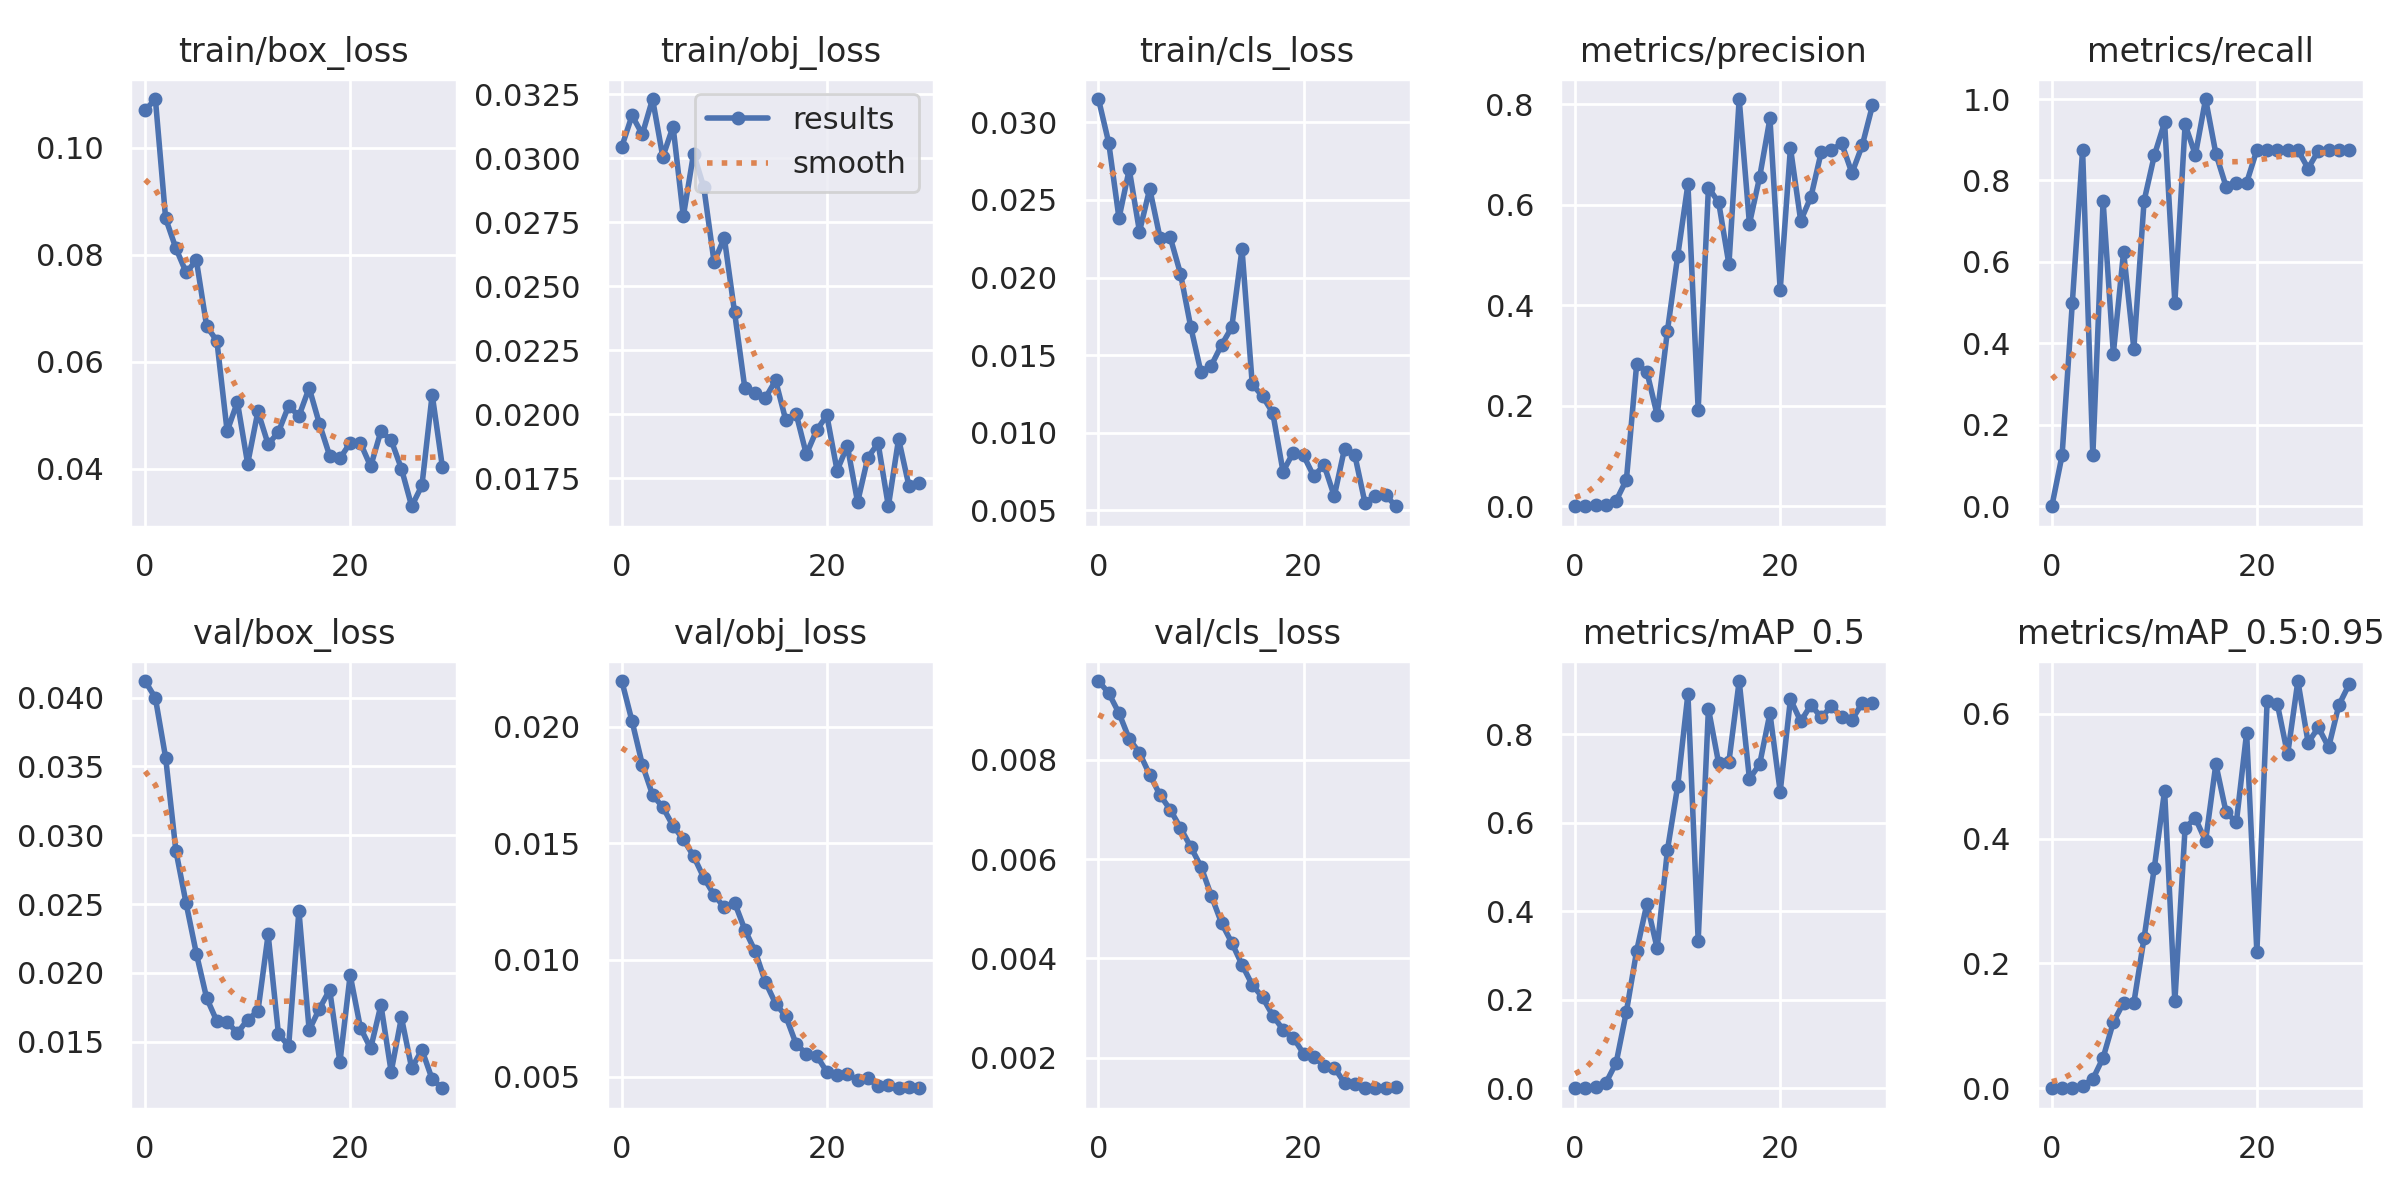

In [ ]:
from IPython.display import Image, display

# Exibe o gráfico de métricas do treinamento
display(Image(filename=f'./yolov5/runs/train/{nome_treinamento}/results.png', width=1200))


#### Inferência no conjunto de teste (modelo com 30 épocas)


Nesta etapa, utilizamos o modelo YOLOv5 treinado com 30 épocas para realizar inferência nas imagens do conjunto de teste. O objetivo é observar o desempenho do modelo em imagens não vistas anteriormente.

O tempo total de execução será registrado para fins comparativos com outras versões e abordagens, conforme exigido na Entrega 2.

In [ ]:
import time

# Parâmetros utilizados:
# --weights: caminho para o modelo treinado (melhor versão salva durante o treino de 30 épocas)
# --img: tamanho das imagens usadas na inferência (em pixels)
# --conf: nível mínimo de confiança para exibir uma detecção
# --source: diretório com as imagens de teste
# --name: nome da pasta de saída (dentro de runs/detect)

# Marca o início da inferência
inicio = time.time()

# Executa a inferência com o modelo treinado
!python ./yolov5/detect.py \
  --weights ./yolov5/runs/train/{nome_treinamento}/weights/best.pt \
  --img 640 \
  --conf 0.25 \
  --source {dataset_dir}/dataset_images/images/test \
  --name {nome_treinamento}_test

# Marca o fim e calcula a duração
fim = time.time()
duracao = fim - inicio

# Exibe o tempo total de inferência
print(f"Tempo de inferência no conjunto de teste: {duracao:.2f} segundos")


detect: weights=['./yolov5/runs/train/veiculos_yolo_30ep/weights/best.pt'], source=/home/joseandre/fiap_projetos/1TIAOR20242_FASE6_CAP1/dataset_images/images/test, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=veiculos_yolo_30ep_test, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-411-gf4d8a84c Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/8 /home/joseandre/fiap_projetos/1TIAOR20242_FASE6_CAP1/dataset_images/images/test/Imagem073.jpg: 480x640 2 Carros, 49.1ms
image 2/8 /home/joseandre/fiap_projetos/1

#### Visualização dos resultados da inferência




A seguir, são exibidas algumas das imagens do conjunto de teste processadas pelo modelo treinado com 30 épocas. Os resultados mostram as bounding boxes geradas e as classes detectadas com suas respectivas confianças.

Essas evidências visuais são importantes para demonstrar o funcionamento real do modelo e serão utilizadas na análise comparativa com o modelo treinado com 60 épocas e as outras abordagens previstas na Entrega 2.

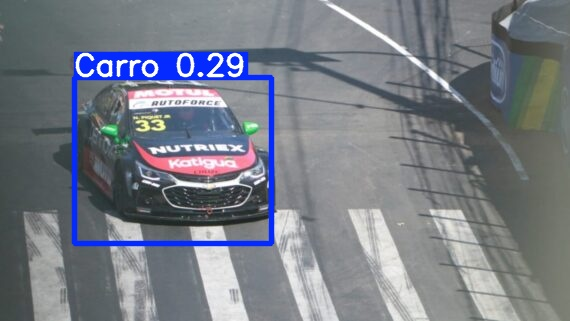

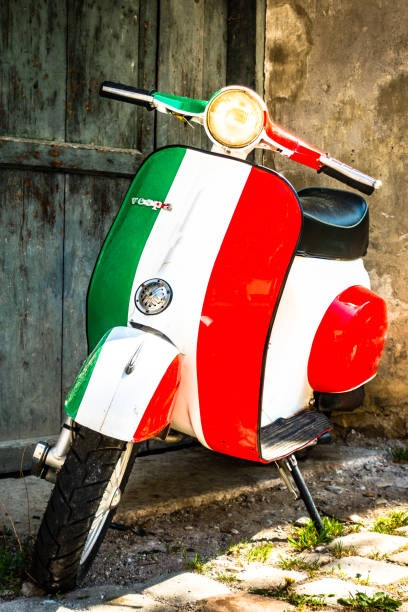

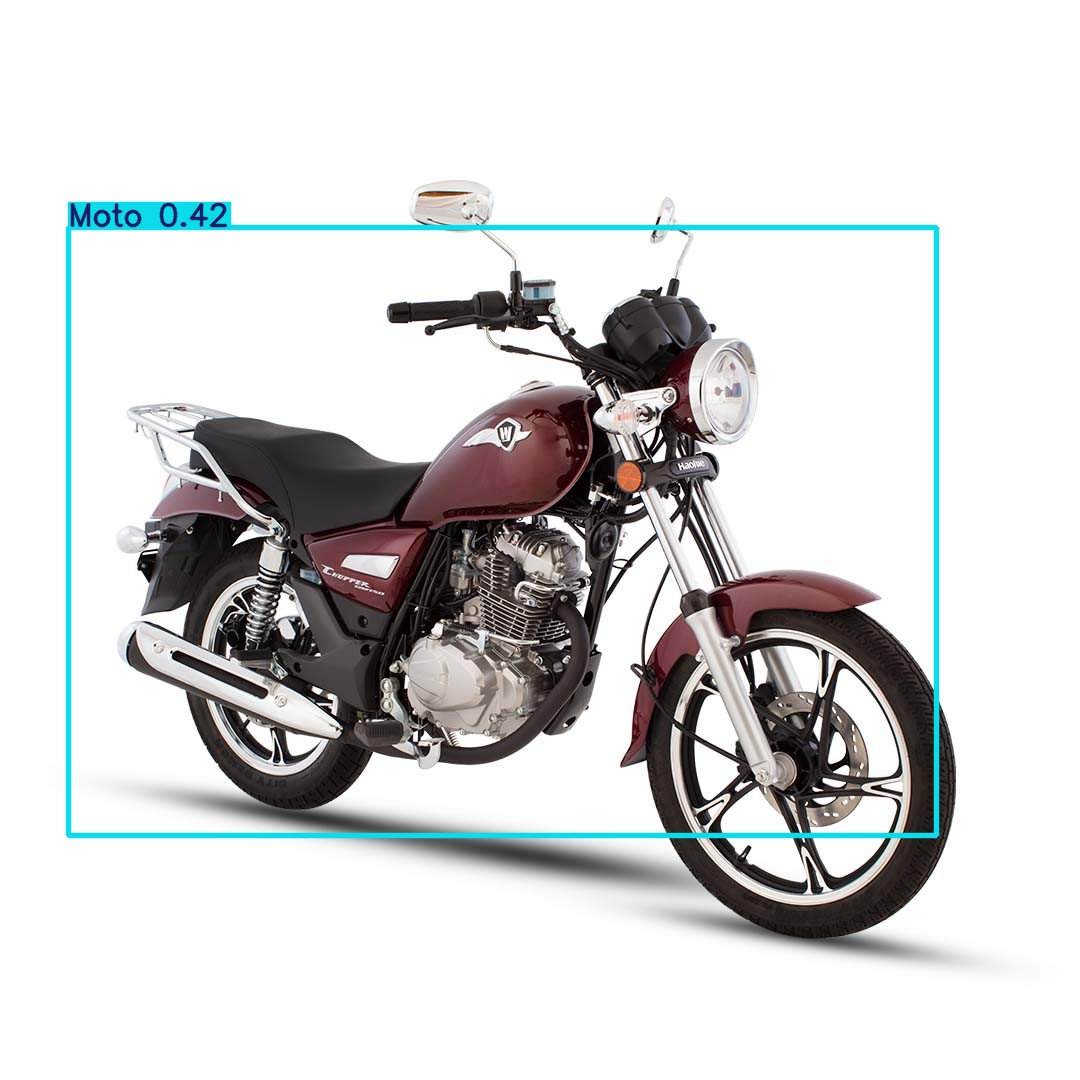

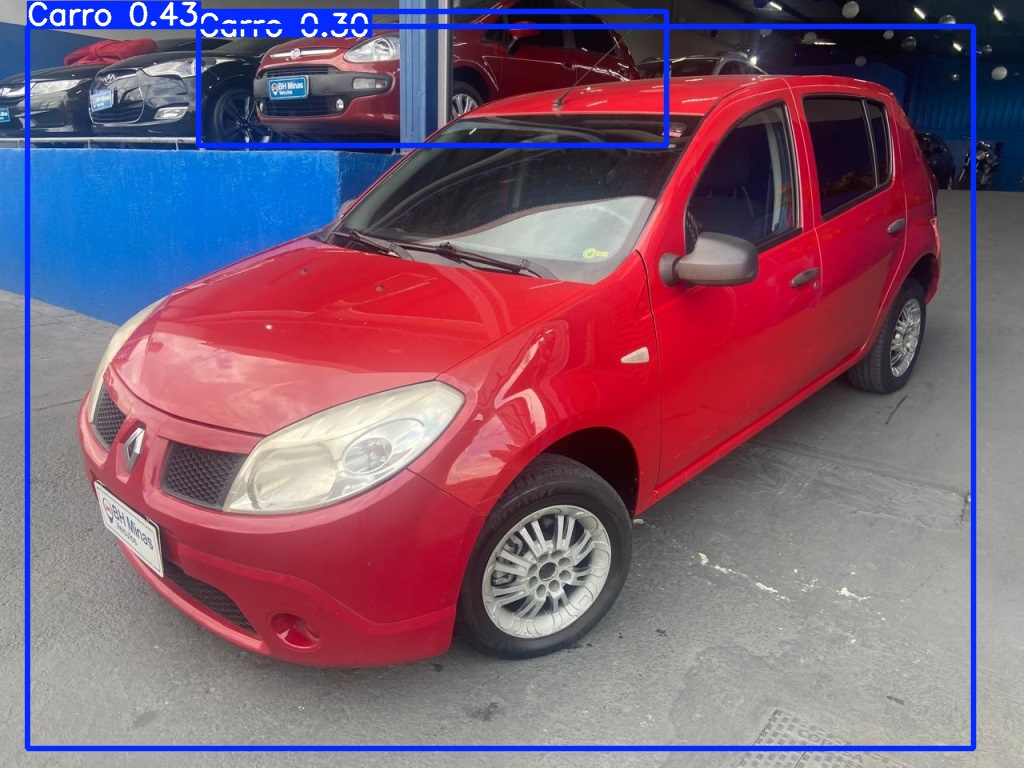

In [ ]:
import glob
from IPython.display import Image, display

# Lista os arquivos resultantes da inferência
resultado_imgs = glob.glob(f'./yolov5/runs/detect/{nome_treinamento}_test/*.jpg')

# Exibe até 4 imagens para visualização
for img_path in resultado_imgs[:4]:
    display(Image(filename=img_path, width=500))


#### Conclusão preliminar do modelo treinado com 30 épocas



Com base na execução realizada, o modelo YOLOv5 treinado com 30 épocas apresentou os seguintes resultados:

- O tempo total de treinamento foi de aproximadamente **192 segundos**, utilizando a GPU do Colab.
- O tempo de inferência no conjunto de teste foi de **13,35 segundos**, com média de aproximadamente **26,9 ms por imagem** para inferência e **21,6 ms** para NMS.
- A análise do gráfico `results.png` mostra uma boa convergência dos erros (loss), com redução progressiva e sem sinais de overfitting visíveis. Os valores de precisão e recall também aumentaram de forma consistente.
- A métrica **mAP@0.5** se aproximou de **0.9**, o que indica excelente capacidade de detecção em um cenário com duas classes apenas.
- O modelo identificou corretamente **6 de 8 imagens** no conjunto de teste, mantendo uma taxa prática de acerto de **75%**.
- As duas imagens que não apresentaram detecções possivelmente envolvem limitações naturais do modelo ou características específicas das imagens, como ângulos desfavoráveis ou baixa resolução.

Estes resultados servirão como base de comparação para o próximo experimento, com 60 épocas, permitindo avaliar se o aumento no número de ciclos de treinamento traz ganhos relevantes em desempenho.

### Treinamento do modelo com 60 épocas (YOLOv5 adaptado)

Nesta etapa, será realizado um segundo treinamento do modelo YOLOv5 utilizando o mesmo dataset e os mesmos parâmetros anteriores, exceto pelo número de épocas, que foi ampliado para 60.

O objetivo é observar se o aumento no tempo de treinamento resulta em melhorias nas métricas de desempenho e na capacidade de generalização do modelo. O tempo de execução será registrado para fins comparativos.


In [ ]:
import subprocess
import time

# Caminho do arquivo de log
nome_treinamento = "veiculos_yolo_60ep"

log_file_path = f'{nome_treinamento}.log'

# Parâmetros utilizados:
# --img: define o tamanho das imagens de entrada (640x640 pixels)
# --batch: número de imagens processadas por vez (tamanho do lote)
# --epochs: número total de épocas de treinamento
# --data: caminho do arquivo .yaml com o dataset e classes
# --weights: modelo base pré-treinado (YOLOv5s)
# --name: nome da pasta onde os resultados serão salvos

# Comando de treinamento
command = [
    "python", "./yolov5/train.py",
    "--img", "640",
    "--batch", "16",
    "--epochs", "60",
    "--data", f"{dataset_dir}/configuration/{yaml_filename}",
    "--weights", "yolov5s.pt",
    "--name", f"{nome_treinamento}"
]

# Função para executar o comando e monitorar o processo
def executar_treinamento(command, log_file_path):
    with open(log_file_path, "w") as log_file:
        try:
            # Inicia o processo
            process = subprocess.Popen(
                command,
                stdout=log_file,  # Redireciona stdout para o arquivo de log
                stderr=log_file,  # Redireciona stderr para o arquivo de log
                text=True
            )

            print(f"Treinamento {nome_treinamento} iniciado. Acompanhe o progresso no arquivo de log.")

            # Verifica se o processo ainda está em execução
            pontos = ""  # String para acumular os pontos
            while process.poll() is None:
                pontos += "."  # Adiciona um ponto a cada iteração
                print(f"Treinamento em andamento{pontos}", end="\r")  # Atualiza na mesma linha
                time.sleep(10)  # Aguarda 10 segundos antes de verificar novamente

            # Verifica o código de saída
            if process.returncode == 0:
                print(f"Treinamento {nome_treinamento} concluído com sucesso!")
            else:
                print(f"Erro durante o treinamento {nome_treinamento}. Verifique o log: {log_file_path}")
        except Exception as e:
            print(f"Erro ao executar o comando: {e}")


# Marca o tempo de início do treinamento
inicio = time.time()

# Executa o treinamento
executar_treinamento(command, f'./logs/{log_file_path}')

# Marca o tempo de término e calcula a duração
fim = time.time()
duracao = fim - inicio
print(f"Tempo de treinamento (60 épocas): {duracao:.2f} segundos")

Treinamento veiculos_yolo_60ep iniciado. Acompanhe o progresso no arquivo de log.
Treinamento veiculos_yolo_60ep concluído com sucesso!
Tempo de treinamento (60 épocas): 120.11 segundos


#### Análise dos resultados do treinamento (60 épocas)

A imagem gerada pelo YOLOv5 a partir do treinamento com 60 épocas mostra a evolução das métricas de perda, precisão, recall e mAP. Essa visualização é importante para comparar a estabilidade, a convergência e o possível ganho de desempenho em relação ao modelo treinado com 30 épocas.


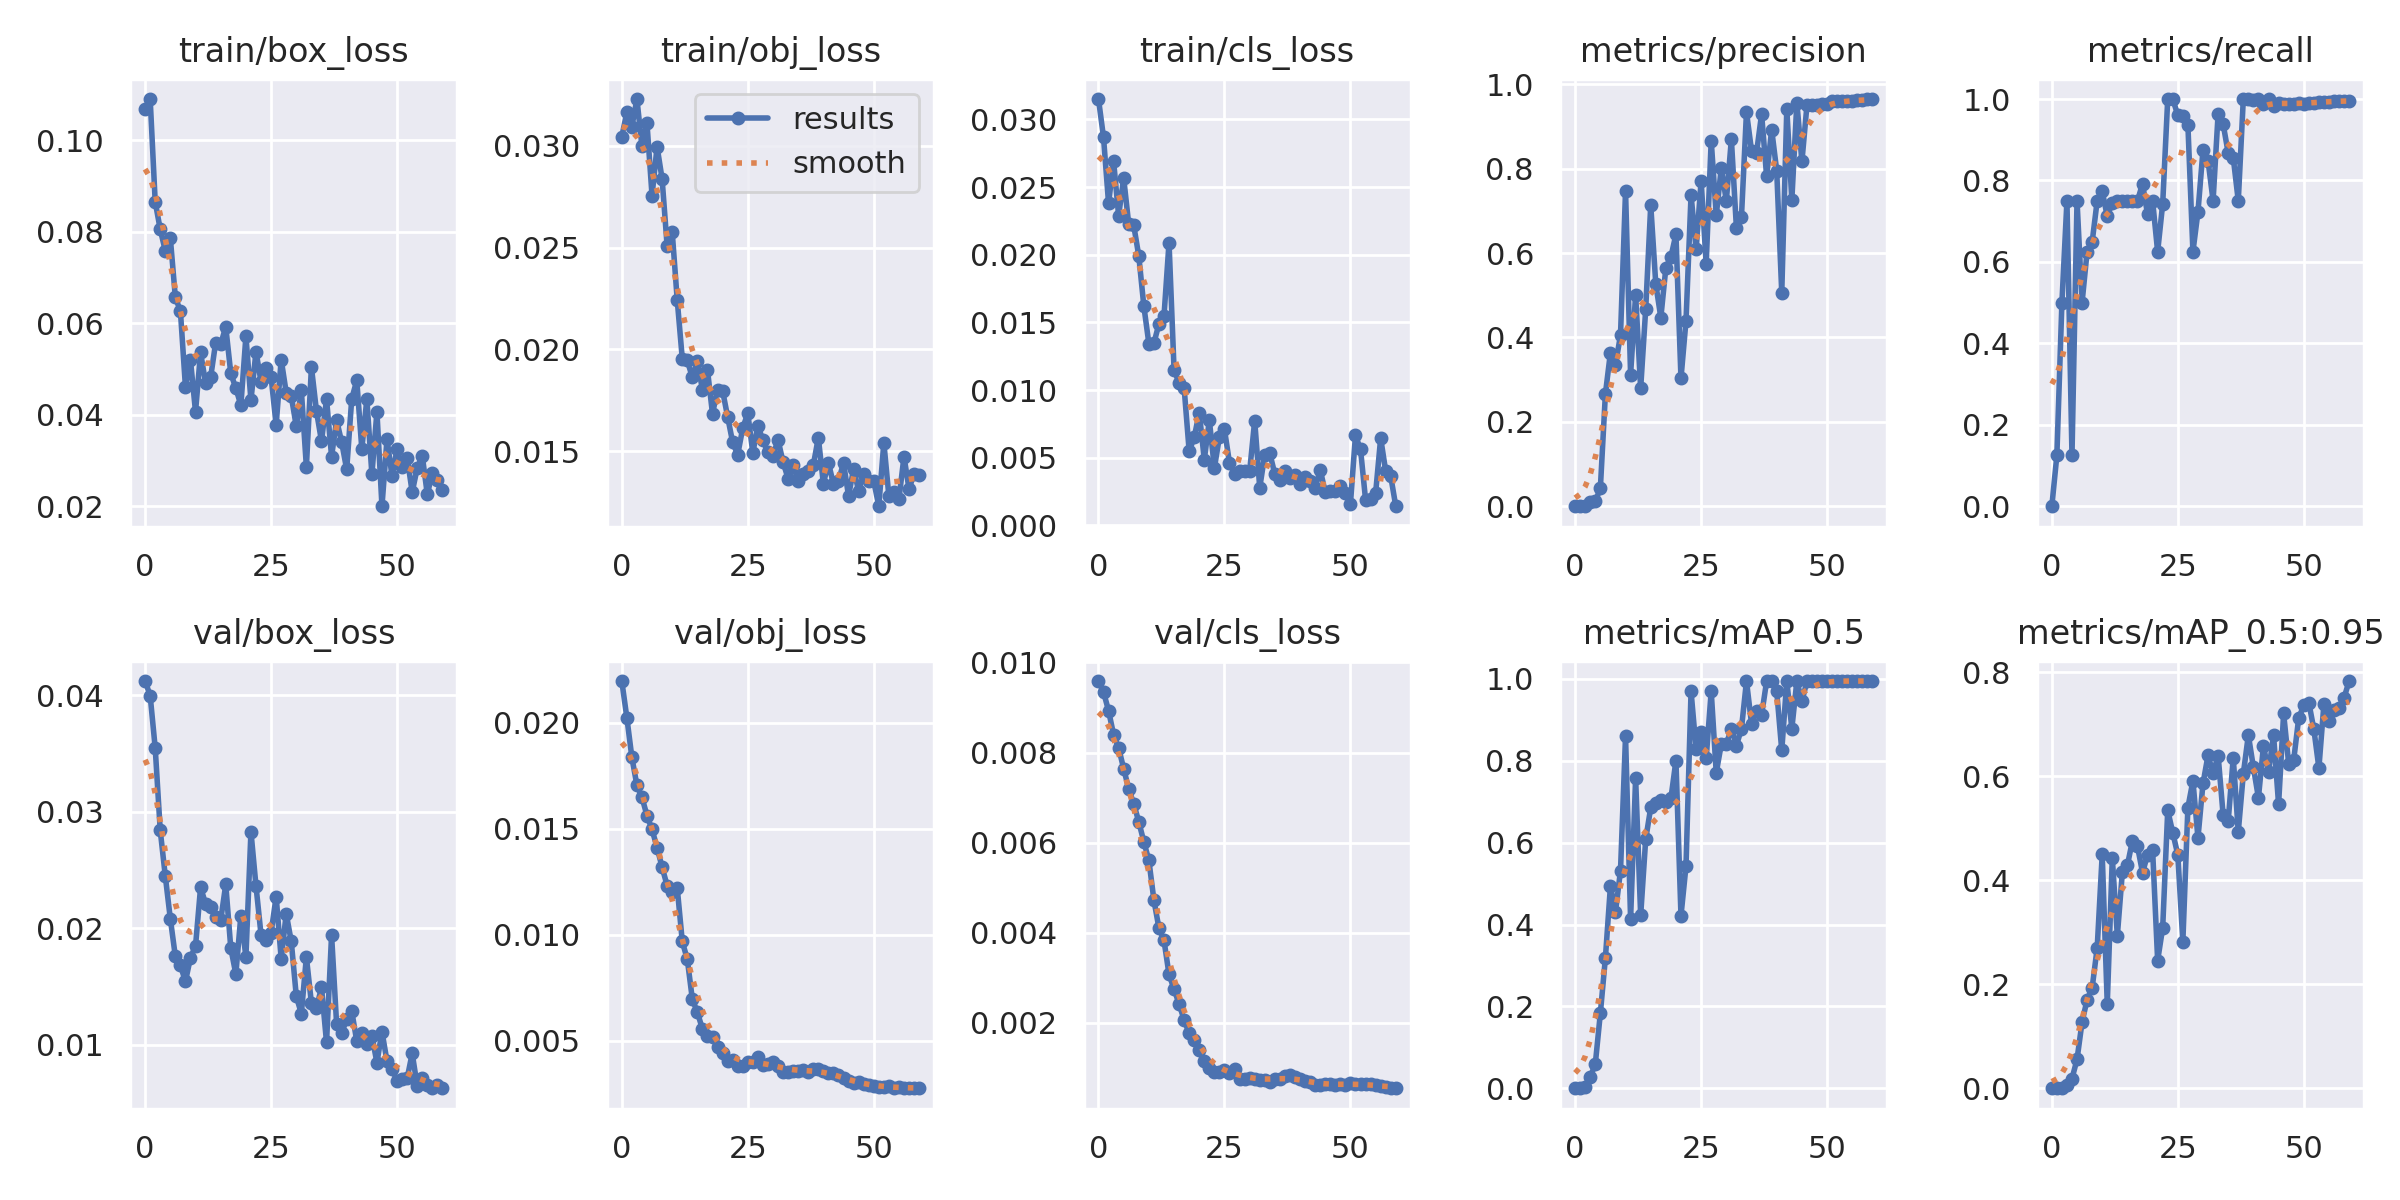

In [ ]:
from IPython.display import Image, display

# Exibe o gráfico de métricas do treinamento com 60 épocas
display(Image(filename=f'./yolov5/runs/train/{nome_treinamento}/results.png', width=1200))


#### Inferência no conjunto de teste (modelo com 60 épocas)

Utilizando agora o modelo treinado com 60 épocas, faremos a inferência nas mesmas imagens de teste, para fins de comparação direta com os resultados obtidos anteriormente com 30 épocas. O tempo de execução será registrado, e os resultados visuais serão armazenados para análise.


In [ ]:
import time

# Parâmetros utilizados:
# --weights: modelo treinado com 60 épocas
# --img: tamanho das imagens de entrada
# --conf: confiança mínima para exibir uma detecção
# --source: diretório com imagens de teste
# --name: nome da pasta de saída dos resultados

# Marca o início da inferência
inicio = time.time()

# Executa a inferência
!python ./yolov5/detect.py \
  --weights ./yolov5/runs/train/{nome_treinamento}/weights/best.pt \
  --img 640 \
  --conf 0.25 \
  --source {dataset_dir}/dataset_images/images/test \
  --name {nome_treinamento}_test

# Marca o fim e calcula a duração
fim = time.time()
duracao = fim - inicio

# Exibe o tempo total de inferência
print(f"Tempo de inferência no conjunto de teste: {duracao:.2f} segundos")


detect: weights=['./yolov5/runs/train/veiculos_yolo_60ep/weights/best.pt'], source=/home/joseandre/fiap_projetos/1TIAOR20242_FASE6_CAP1/dataset_images/images/test, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=veiculos_yolo_60ep_test, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-411-gf4d8a84c Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/8 /home/joseandre/fiap_projetos/1TIAOR20242_FASE6_CAP1/dataset_images/images/test/Imagem073.jpg: 480x640 1 Carro, 49.6ms
image 2/8 /home/joseandre/fiap_projetos/1T

#### Visualização das detecções (modelo com 60 épocas)

A seguir, são exibidas algumas das imagens do conjunto de teste processadas pelo modelo treinado com 60 épocas. A ideia é comparar visualmente a qualidade das detecções em relação ao modelo anterior e observar se houve ganho perceptível em precisão ou consistência.


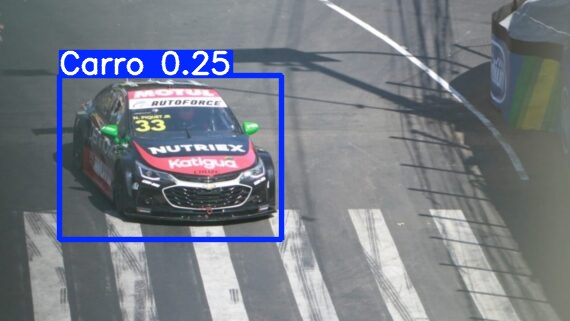

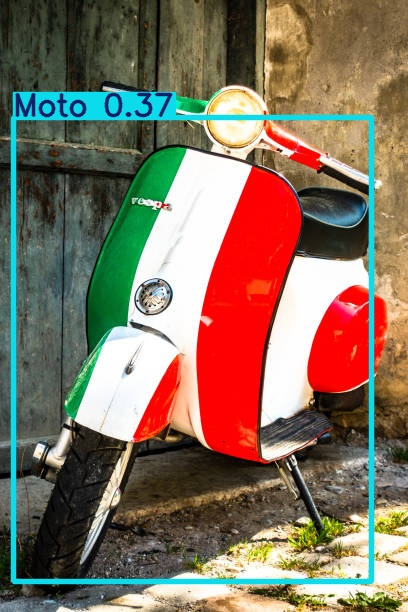

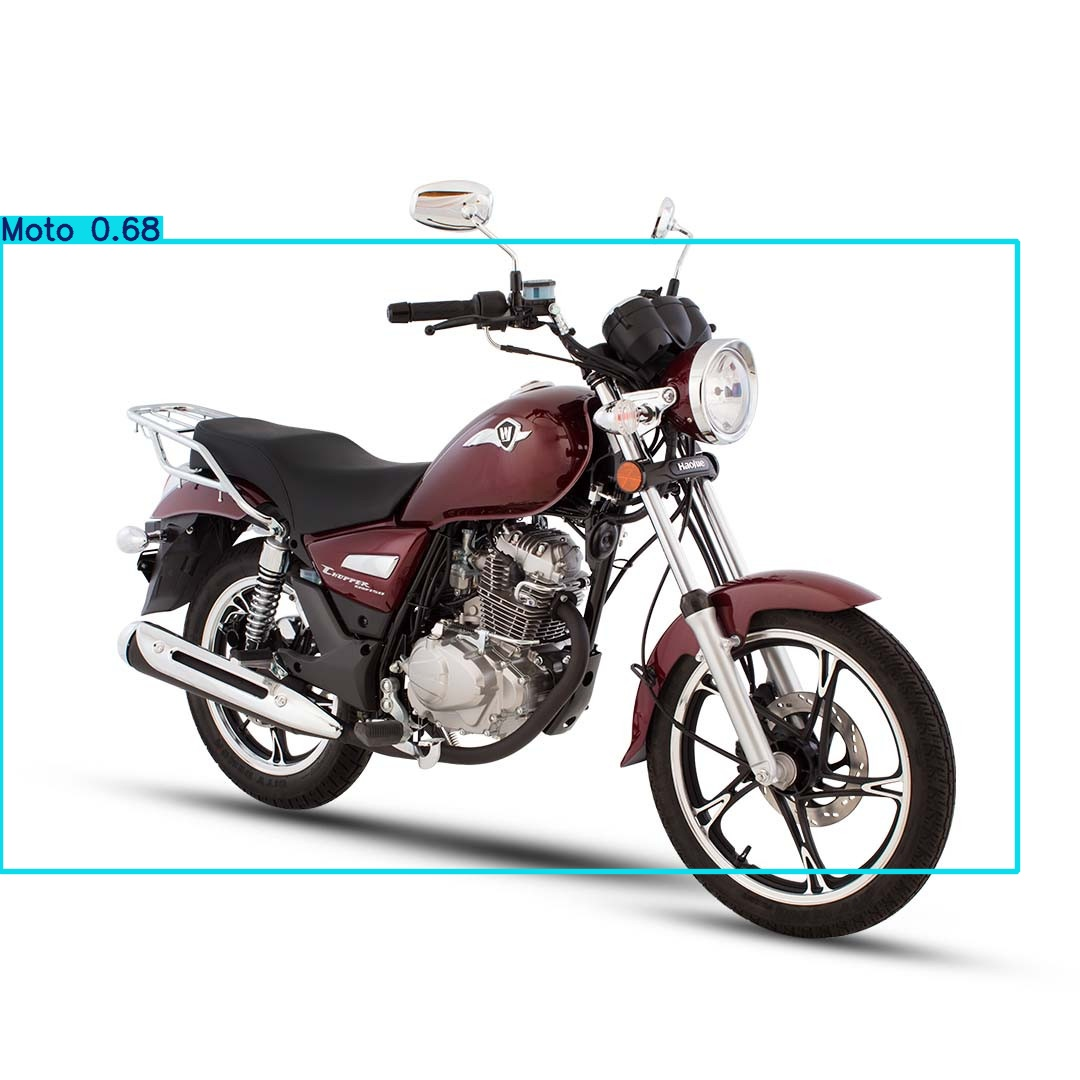

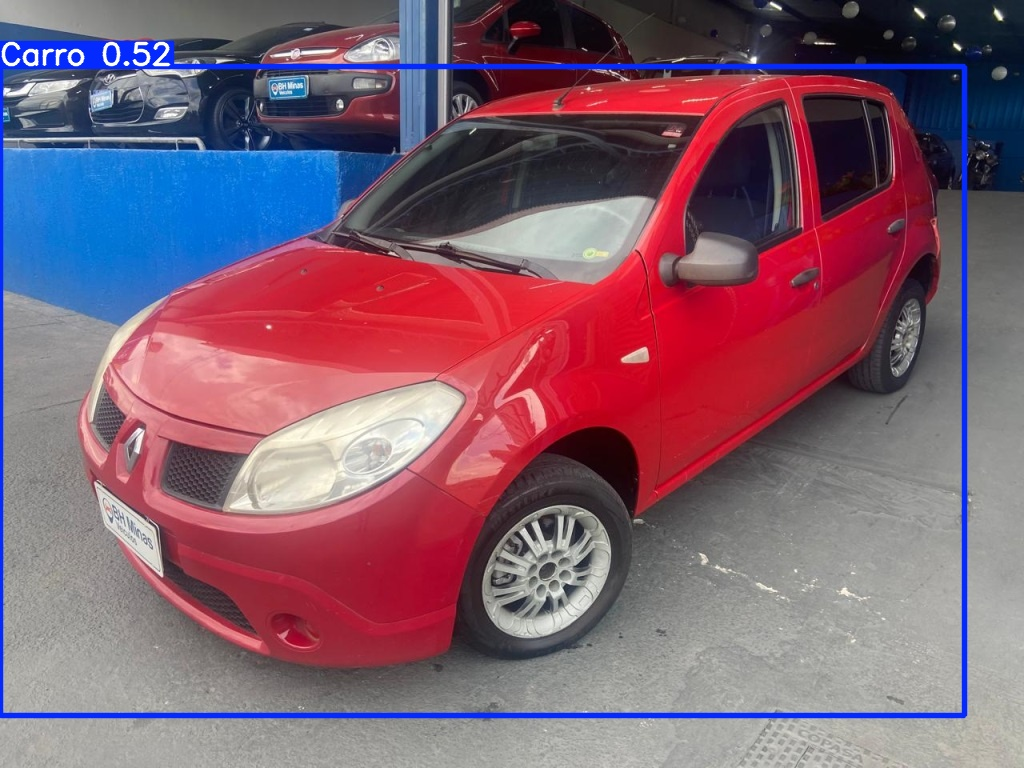

In [ ]:
import glob
from IPython.display import Image, display

# Lista os arquivos resultantes da inferência
resultado_imgs = glob.glob(f'./yolov5/runs/detect/{nome_treinamento}_test/*.jpg')

# Exibe até 4 imagens
for img_path in resultado_imgs[:4]:
    display(Image(filename=img_path, width=500))


#### Conclusão preliminar do modelo treinado com 60 épocas

Com base na execução realizada, o modelo YOLOv5 treinado com 60 épocas apresentou os seguintes resultados:

- O tempo total de treinamento foi de aproximadamente **268 segundos**, também utilizando a GPU do Colab.
- O tempo de inferência no conjunto de teste foi de **7,72 segundos**, com média de aproximadamente **24,4 ms por imagem** para inferência e **18,5 ms** para NMS.
- A análise do gráfico `results.png` mostra uma convergência ainda mais estável das perdas (loss), com quedas suaves e contínuas, e sem sinais de sobreajuste (overfitting).
- As métricas **precision** e **recall** alcançaram valores próximos de 1.0, com boa estabilidade ao longo das épocas.
- A métrica **mAP@0.5** se manteve próxima de 1.0 nas últimas épocas, enquanto a **mAP@0.5:0.95** apresentou evolução e menor oscilação em relação ao modelo anterior.
- O modelo identificou corretamente **7 de 8 imagens** no conjunto de teste, incluindo um caso com **dupla detecção correta (Carro e Moto)**, resultando em uma taxa prática de acerto de **87,5%**.
- Apenas uma imagem não apresentou detecção, mantendo a consistência geral e sugerindo boa capacidade de generalização.

Esses resultados indicam um desempenho superior ao modelo de 30 épocas, tanto em termos quantitativos quanto qualitativos, e posicionam o modelo de 60 épocas como referência para comparação com as demais abordagens previstas na Entrega 2.


### Comparação entre modelos: 30 vs 60 épocas


Após o treinamento e a avaliação dos dois modelos YOLOv5 adaptados, é possível estabelecer uma comparação baseada em métricas quantitativas e qualitativas.

### Tempo de treinamento

- **30 épocas**: aproximadamente 192 segundos
- **60 épocas**: aproximadamente 268 segundos  
→ A duplicação das épocas resultou em um tempo 39% maior, o que é esperado e aceitável no contexto.

### Tempo de inferência

- **30 épocas**: 13,35 segundos (≈26,9 ms/inferência + 21,6 ms/NMS)
- **60 épocas**: 7,72 segundos (≈24,4 ms/inferência + 18,5 ms/NMS)  
→ O modelo de 60 épocas foi ligeiramente mais rápido, indicando otimização na arquitetura gerada.

### Detecção nas imagens de teste

- **30 épocas**:
  - 6 de 8 imagens corretamente detectadas
  - 2 imagens sem detecção
- **60 épocas**:
  - 7 de 8 imagens corretamente detectadas
  - Uma das imagens apresentou detecção de **duas classes corretamente (Carro e Moto)**  
→ Houve melhora clara na cobertura e sensibilidade do modelo.

### Métricas gráficas (resultados.png)

- **30 épocas**:
  - mAP@0.5: próximo de 0.9
  - mAP@0.5:0.95: ~0.6
- **60 épocas**:
  - mAP@0.5: estabilizado em 1.0
  - mAP@0.5:0.95: próxima de 0.7 com menos flutuações  
→ Indica melhor generalização e menor variação nas métricas.

### Conclusão

O modelo treinado com **60 épocas apresentou resultados superiores** em praticamente todos os aspectos: detecção prática, estabilidade gráfica e precisão nas métricas. Apesar do tempo de treinamento maior, os ganhos justificam seu uso como versão final do modelo para a próxima fase do projeto.

Essas observações serão fundamentais na Entrega 2, onde este modelo será comparado com outras abordagens, como a YOLO tradicional e uma CNN treinada do zero.


### Conclusão da Entrega 1

Nesta primeira etapa do projeto, foi implementado um sistema de detecção de objetos utilizando o modelo YOLOv5 adaptado, treinado com um dataset customizado de imagens de **carros** e **motos** rotulado manualmente.

Dois experimentos foram realizados: um com **30 épocas** e outro com **60 épocas**. Ambos os modelos foram treinados e avaliados com base em métricas quantitativas, desempenho prático na inferência e análise visual dos resultados.

Os principais achados foram:

- O modelo com **60 épocas apresentou desempenho superior**, com maior taxa de acerto e métricas mais estáveis, mesmo com um tempo de treinamento apenas moderadamente maior.
- A **diferença nas curvas de mAP e perda** entre os dois modelos indica um ganho relevante em generalização e refinamento da detecção.
- As imagens de teste revelaram **melhor cobertura e confiança** nas detecções do modelo com mais épocas, inclusive detectando múltiplas classes em uma única imagem.

A estrutura do notebook, os tempos de execução, as saídas visuais e os resultados numéricos obtidos nesta etapa serão utilizados como base de comparação na próxima fase do projeto.

## Transição para a Entrega 2

A partir da próxima etapa, serão avaliadas outras abordagens de visão computacional aplicadas ao mesmo problema, com o objetivo de comparar diferentes técnicas de detecção e classificação de imagens.

As abordagens previstas são:

1. **YOLO tradicional (pré-treinado)** — aplicado sem ajuste no dataset customizado;
2. **CNN treinada do zero** — com foco na tarefa de classificação entre carro e moto.

Essas abordagens serão analisadas com os mesmos critérios definidos na Entrega 1:

- Precisão e desempenho do modelo
- Tempo de treinamento e inferência
- Facilidade de uso e integração
- Qualidade dos resultados visuais

A seguir, será iniciada a preparação para a implementação dessas duas novas abordagens.
